### The data set has information about features of silhouette extracted from the images of different cars

Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import sklearn as sk
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (15,7)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('vehicle.csv')
data.shape

In [4]:
data.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

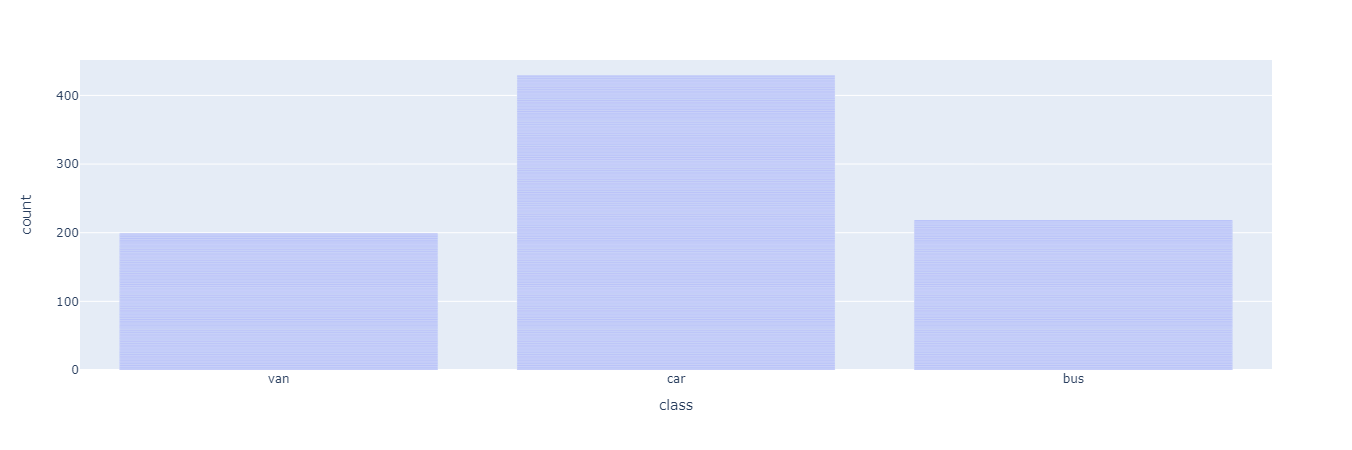

In [5]:
# data['class'].value_counts().plot(kind='bar')
fig = px.bar(data, x = 'class')
fig.show()

In [32]:
check_astype = []

for col in data.columns:
    unique = data[col].nunique()
#     print(col,' : ',unique)

    if unique > 15:
        data[col] = data[col].astype('float')
        
    elif unique < 6:
        data[col] = data[col].astype('object')
        
    else:
        check_astype.append(col)

In [6]:
data.isnull().sum();
data.dropna(inplace=True) #Lets drop 

In [ ]:
#Plotting Each attribute wrt target
for col in data.columns[:-1]:
    print(col)
    
    fig = px.box(data, y=col, color=data['class'])
    fig.show()
    
    g = sns.FacetGrid(data, hue="class", aspect=5,height=5)
    pl = g.map(sns.distplot, col ,  hist=False, rug=True)
    plt.legend()
    plt.show()
    
    print('#'*100)
    print( '')

* Most of the features are Multi-modal, But values of Van and Bus are overlapping in most of the features.

In [8]:
def check_mutlicolinearity(data_x):
    corr = data_x.corr()
    corr = pd.DataFrame(np.tril(corr, k=-1),      # gets Lower triangular matrix
                        columns=data_x.columns,
                        index=data_x.columns)  

    corr = corr.replace(0.000000, np.NAN)
    count_of_total_correlation_values = corr.count().sum()

    for i in [0.5, 0.6, 0.7, 0.8, 0.9]:
        data_corr = corr[abs(corr) > i]
        count_greater_than_thresh = data_corr.count().sum()
        print(f'Percent Values Greater than {i} co-relation : {count_greater_than_thresh/count_of_total_correlation_values}')
    return corr

In [9]:
def plot_corr(threshold, corr):
    data_corr = corr[abs(corr) > threshold]
    sns.heatmap(data_corr, annot=True)
    plt.show()

In [10]:
data_x = data.drop(columns='class')
data_target = data['class']

corr = check_mutlicolinearity(data_x)

Percent Values Greater than 0.5 co-relation : 0.39215686274509803
Percent Values Greater than 0.6 co-relation : 0.37254901960784315
Percent Values Greater than 0.7 co-relation : 0.3333333333333333
Percent Values Greater than 0.8 co-relation : 0.19607843137254902
Percent Values Greater than 0.9 co-relation : 0.0915032679738562


* As ~30% of features are correlated, We can reduce the redundancy using PCA.

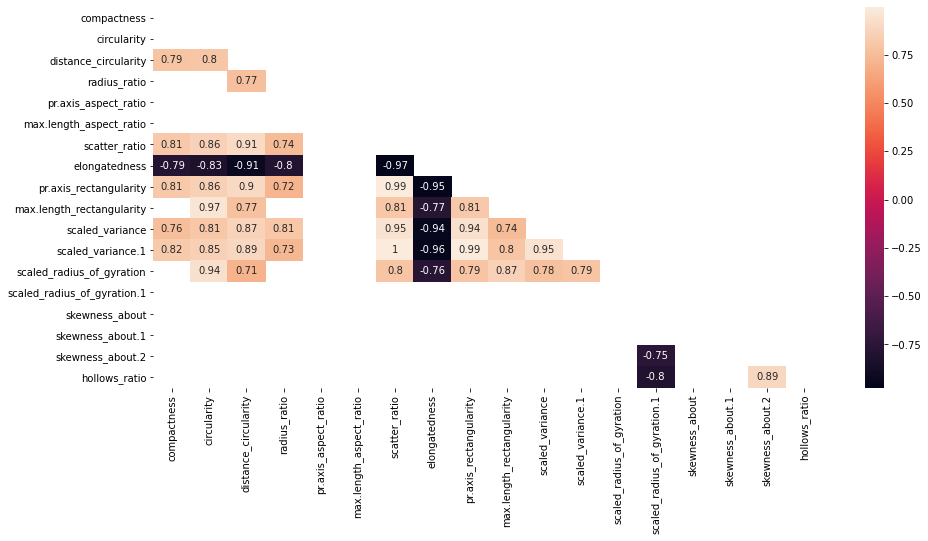

In [11]:
plot_corr(0.7, corr)

In [12]:
from scipy.stats import zscore

data_x_std = data_x.apply(zscore)  #standardizing the data : mean = 0, SD = 1

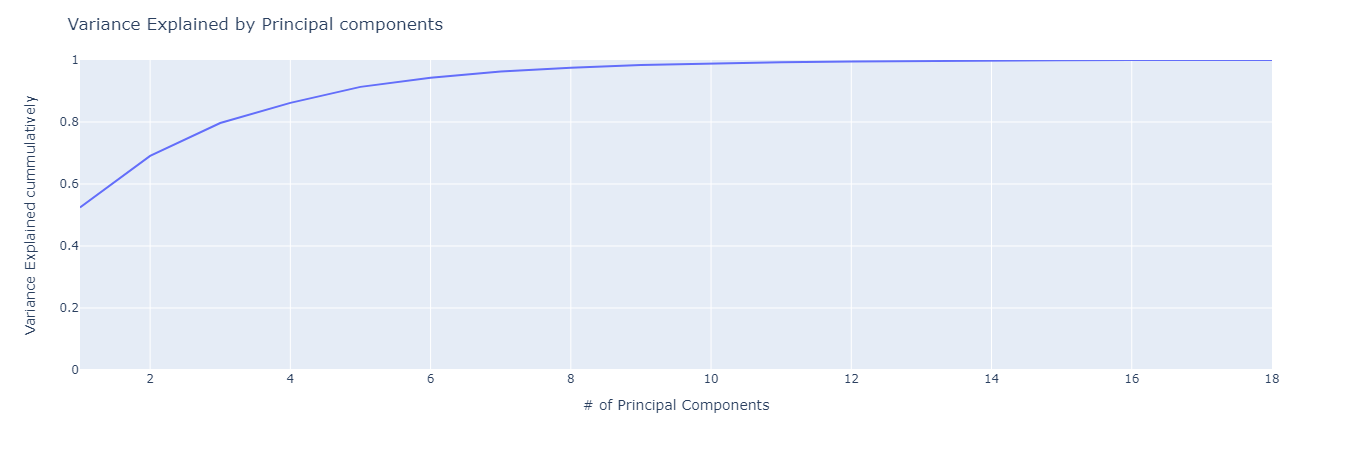

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=18, random_state=6)
data_pca = pca.fit_transform(data_x_std)  # we need to standardize the data before pca

fig = px.line(y=pca.explained_variance_ratio_.cumsum(),
              x=range(1, 19),
              range_y=(0, 1))
fig.update_layout(title='Variance Explained by Principal components',
                  xaxis_title='# of Principal Components',
                  yaxis_title='Variance Explained cummulatively')
fig.show()

From 11^th component we are getting 99.2 % variance, lets have 10 components.

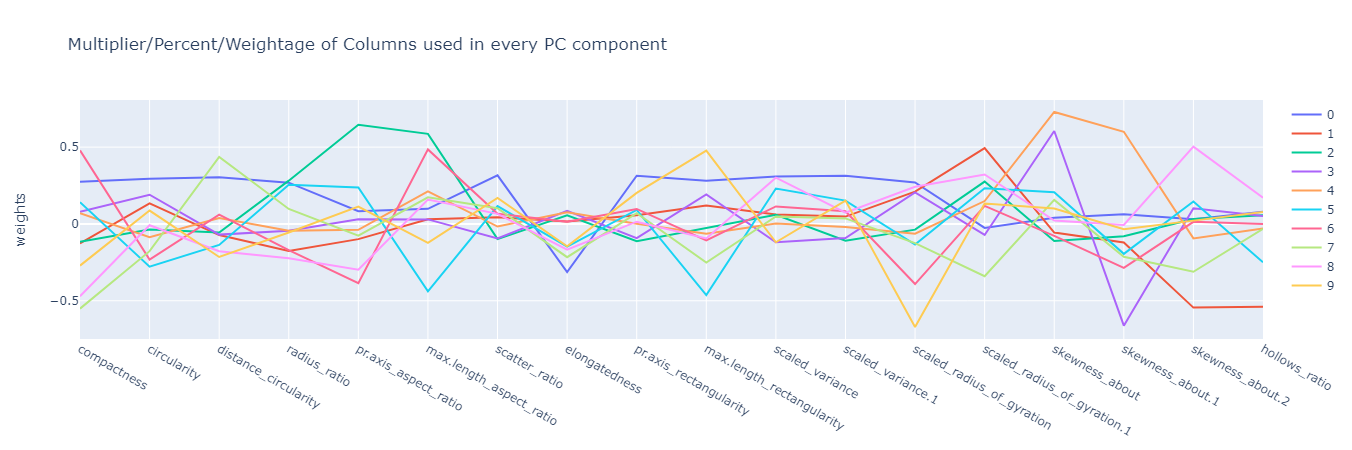

In [14]:
n_components = 10  # Number of PC dimensions

pca = PCA(n_components=n_components, random_state=6)
data_pca = pca.fit_transform(data_x_std)  # we need to standardize the data before pca

from plotly import graph_objects as go
fig = go.Figure()
for n_comp in range(0, n_components):
    fig.add_trace(
        go.Scatter(y=pca.components_[n_comp],
                   x=data_x_std.columns,
                   mode='lines',
                   name=n_comp))
fig.update_layout(
    title='Multiplier/Percent/Weightage of Columns used in every PC component',
    yaxis_title='weights')
fig.show()

select individual pc component to get the related weights

In [15]:
# corr = check_mutlicolinearity(pd.DataFrame(data_pca))

## K-Means Clusttering

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics


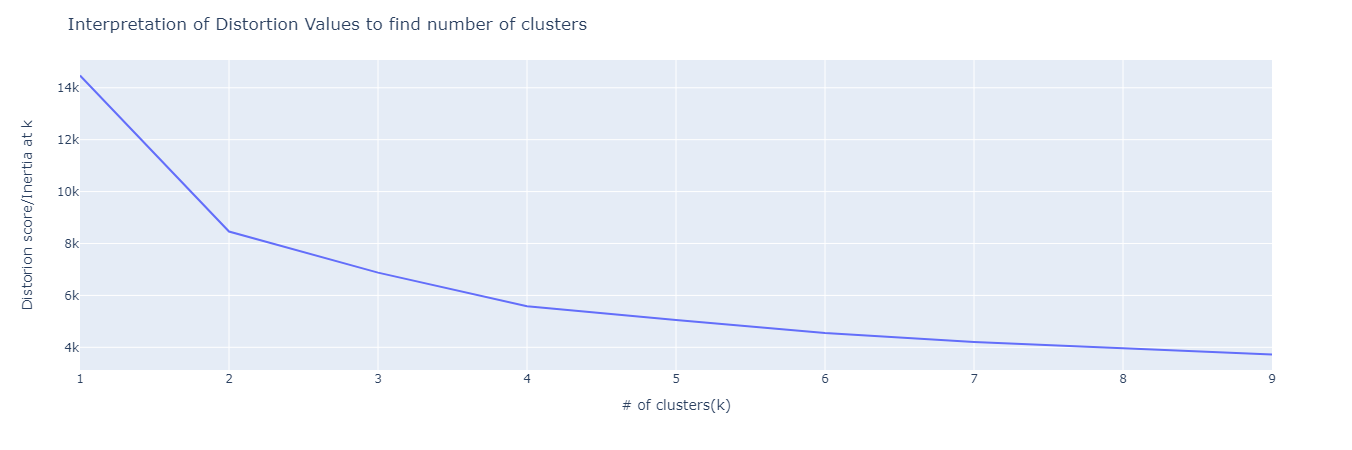

In [17]:
wcss = []
# silhouette =[]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)
#     silhouette.append(metrics.silhouette_score(data_pca,kmeans.labels_))

# Visualization of k values:

fig = px.line(x=range(1, 10), y=wcss)

fig.update_layout(
    title='Interpretation of Distortion Values to find number of clusters',
    xaxis_title='# of clusters(k)',
    yaxis_title='Distorion score/Inertia at k')
fig.show()

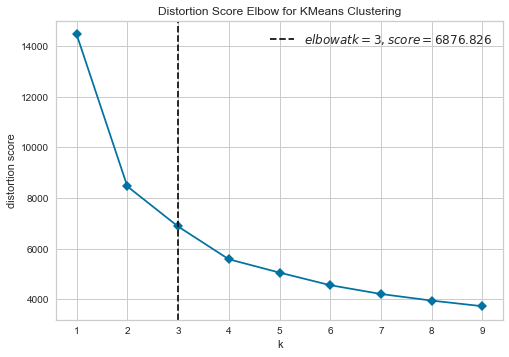

In [18]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10),timings=False)  # Automatically finds the best K values based on algorithm

visualizer.fit(data_pca)  # Fit the data to the visualizer
visualizer.show()
plt.show()

From the Manual Graph we interpret that k = 4 but the algorithm finds the best value at k = 3, Lets find the optimal value based on centorids.

In [19]:
model = KMeans(n_clusters=3, n_init=20, random_state=2)
model.fit(data_pca)

KMeans(n_clusters=3, n_init=20, random_state=2)

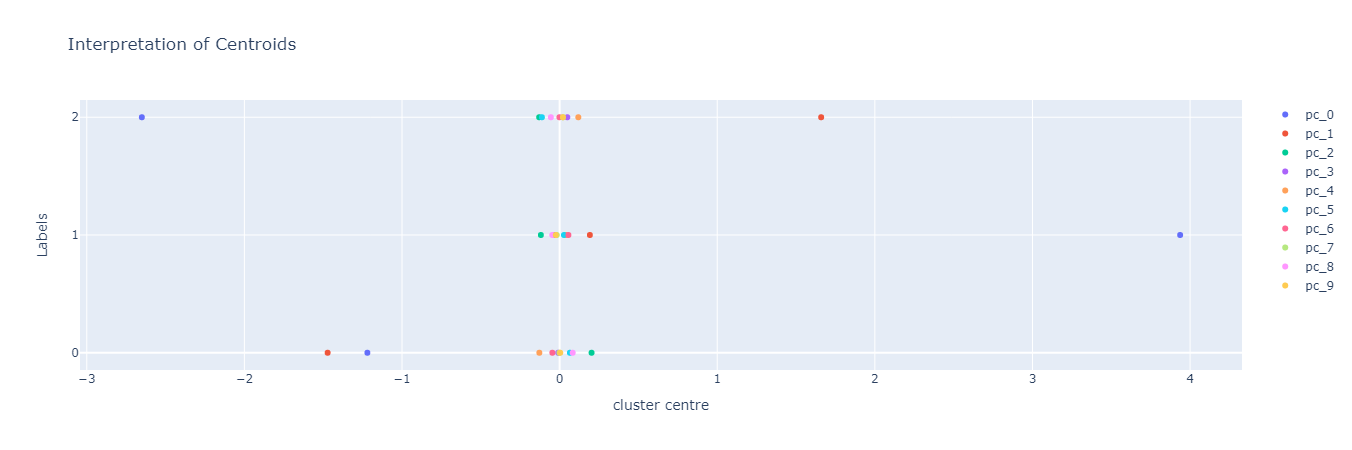

In [20]:
centroids=model.cluster_centers_
centroid_df = pd.DataFrame(centroids )

fig = go.Figure()
for i in centroid_df.columns:
     fig.add_trace (go.Scatter(y = np.arange(0,model.n_clusters) ,x = centroid_df[i],
                    mode='markers', name='pc_'+str(i)))
        
        
fig.update_layout(title=' Interpretation of Centroids',
                   xaxis_title='cluster centre',
                   yaxis = dict(tickvals = [0,1,2], title = 'Labels')
                 )

fig.show()

In [21]:
print(
    """The best value for Silhoutte Co-efficient is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.Negative values generally indicate that a sample hasbeen assigned to the wrong cluster, as a different cluster is more similar.
    
The Silhouette Coefficient is calculated using the mean intra-cluster distance (``a``) and the mean nearest-cluster distance (``b``) for each sample.The Silhouette Coefficient for a sample is ``(b - a) / max(a,b)``.To clarify, ``b`` is the distance between a sample and the nearestcluster that the sample is not a part of.
""")
print(f'silhouette_score : {metrics.silhouette_score(data_pca,model.labels_)}')

The best value for Silhoutte Co-efficient is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.Negative values generally indicate that a sample hasbeen assigned to the wrong cluster, as a different cluster is more similar.
    
The Silhouette Coefficient is calculated using the mean intra-cluster distance (``a``) and the mean nearest-cluster distance (``b``) for each sample.The Silhouette Coefficient for a sample is ``(b - a) / max(a,b)``.To clarify, ``b`` is the distance between a sample and the nearestcluster that the sample is not a part of.

silhouette_score : 0.29509109628379315


In [22]:
silhoute_scores = metrics.silhouette_samples(data_pca, model.labels_)

Silhouette Coefficient for each sample and the average Silhouette Coefficient

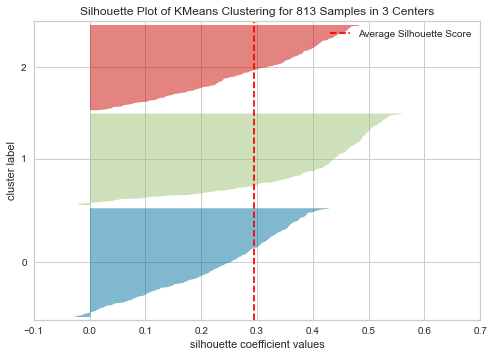

In [23]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(data_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

In [24]:
data['predicted'] = model.labels_
data['predicted'].value_counts()

0    310
1    260
2    243
Name: predicted, dtype: int64

In [25]:
data.groupby('predicted')['class'].value_counts(normalize = True)

predicted  class
0          car      0.416129
           van      0.332258
           bus      0.251613
1          car      0.815385
           bus      0.169231
           van      0.015385
2          van      0.362140
           bus      0.341564
           car      0.296296
Name: class, dtype: float64

* Label 1 can  interpret as  Car, because 81% of label 1 are cars
* Label 2 can be assumed as  Van, but only 36% of them are actually Van. 
    If we assume that Bus and Van are same group, then label 2 is predicting 70 % of them
* Label 0 is highly ambiguous

#### for 2 clusters

In [26]:
model_2 = KMeans(n_clusters=2 , n_init=20, random_state=2)
model_2.fit(data_pca)

print(f'silhouette_score : {metrics.silhouette_score(data_pca,model_2.labels_)}')
data['kmeans_2'] = model_2.labels_

print(data['kmeans_2'].value_counts())
data.groupby('kmeans_2')['class'].value_counts(normalize = True)

silhouette_score : 0.39414054863854664
1    531
0    282
Name: kmeans_2, dtype: int64


kmeans_2  class
0         car      0.804965
          bus      0.180851
          van      0.014184
1         van      0.359699
          car      0.350282
          bus      0.290019
Name: class, dtype: float64

* Label 0 can be interpret as  Car, because 81% of label 1 are cars.
* Label 1  : If  we assume that Bus and Van are same group, then label 2 is predicting 65 % of them

* By considering 2 clustters, the silhouette_score has increased  from 29%(k = 3) to 39%(k = 2)

## Agglomerative Clustering

In [27]:
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist


Cophenet index helps in finding the best linkage method.

cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
closer it is to 1, the better is the clustering,it represents the tightness of the clusters 

In [28]:
def find_best_linkage(data_, plot = False):
    
    linkage_methods = ['complete','single','average','ward','centroid']
    cophenet_index = []
    for linkage_method in linkage_methods:
        Z = linkage(data_, method=linkage_method)
        cop_index, coph_dists = cophenet(Z , pdist(data_))
        cophenet_index.append(cop_index)

    if plot:
        import plotly.express as px
        
        fig = px.scatter(y = linkage_methods, x = cophenet_index , title='Cophenet index for different linkage methods')
        fig.show()
        
    print(f'Best linkage method : {linkage_methods[np.argmax(cophenet_index)]}')

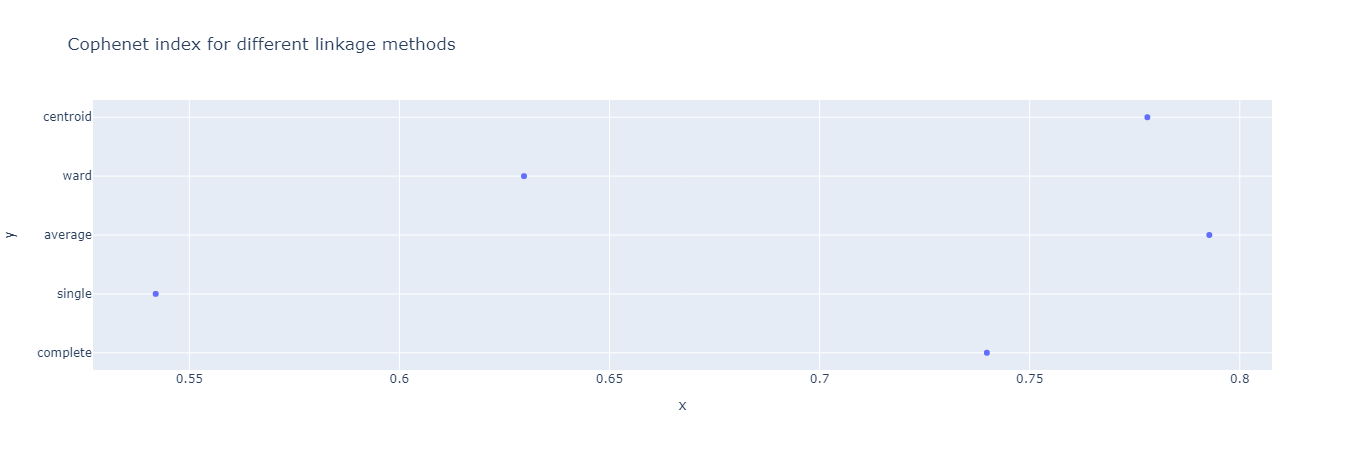

Best linkage method : average


In [29]:
find_best_linkage(data_x_std, plot = True)

In [30]:
find_best_linkage(data_pca, plot = False)

Best linkage method : average


In Agglomerative Hierarchical Clustering We find number of Clusters using Dendogram plot

In [31]:
def plot_dendogram(data,color_threshold , p = 5):
    plt.figure(figsize=(18, 8))
    plt.title('Agglomerative Hierarchical Clustering Dendogram')
    plt.xlabel('sample index')
    plt.ylabel('Distance')

    Z = linkage(data, 'average')
    dendrogram(Z,leaf_rotation=90.0,color_threshold = color_threshold,
               leaf_font_size=10,truncate_mode='level',p=p)
    plt.tight_layout()

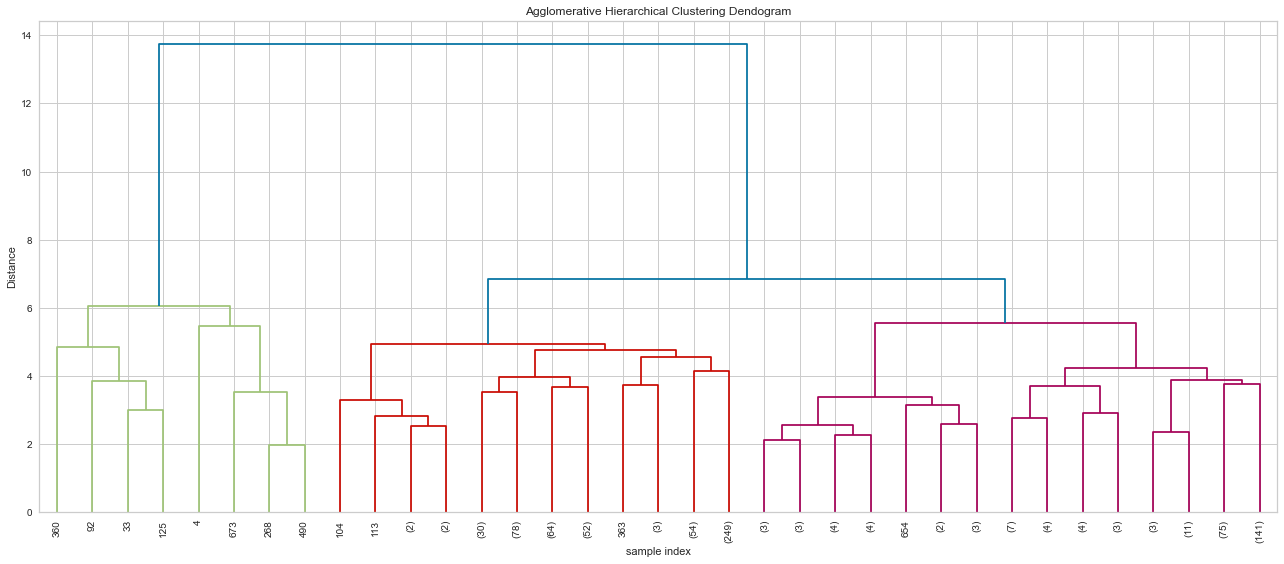

In [32]:
plot_dendogram(data_pca, color_threshold = 6.3)

From the fig we can say there are 2 classes, but the 2nd class is having only 8 samples 
So, we remove the 8 samples and replot it.

In [33]:
# model_2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
model = AgglomerativeClustering(n_clusters=None , distance_threshold= 6.3
                                  , affinity='euclidean',  linkage='average')

# model_2.fit(data_x_std)
model.fit(data_pca);

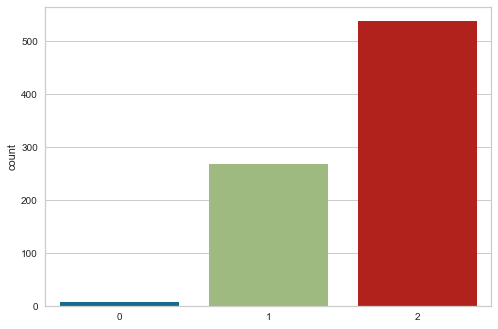

In [34]:
sns.countplot(model.labels_)

In [35]:
data_pca_copy = pd.DataFrame(data_pca).copy(deep = True)
data_pca_copy['target'] = data['class']
data_pca_copy['alggo_labels'] = model.labels_

data_pca_updated = data_pca_copy[data_pca_copy.alggo_labels != 0] #removing the 8 samples
data_pca_updated_x = data_pca_updated.drop(columns=['target','alggo_labels'])

In [36]:
find_best_linkage(data_pca_updated_x)

Best linkage method : average


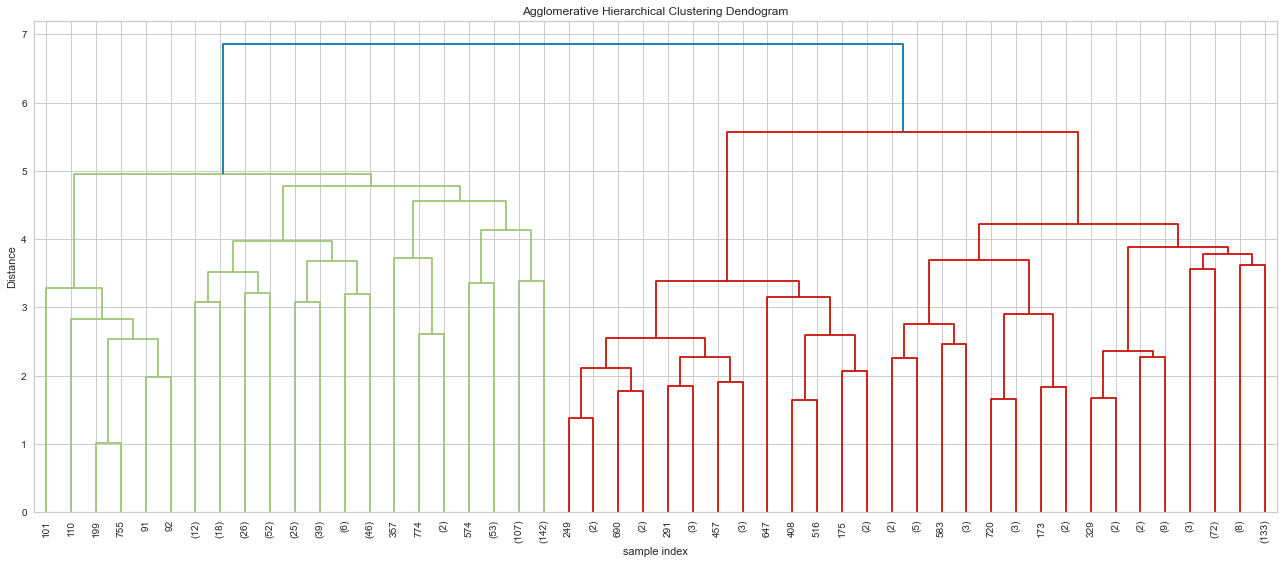

In [37]:
plot_dendogram(data_pca_updated_x, color_threshold = 6)

In [38]:
model = AgglomerativeClustering(n_clusters=None , distance_threshold= 6
                                  , affinity='euclidean',  linkage='average')
model.fit(data_pca_updated_x);

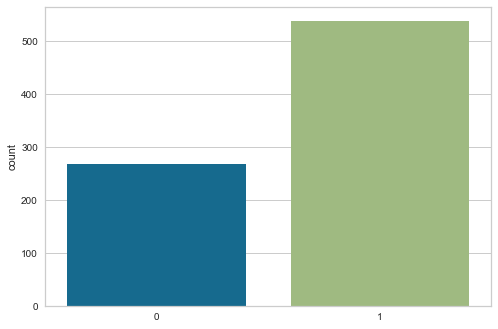

In [39]:
sns.countplot(model.labels_)

In [40]:
data_pca_updated['label_agglo__clus'] = model.labels_
data_pca_updated.groupby('label_agglo__clus')['target'].value_counts(normalize = True)

label_agglo__clus  target
0                  car       0.465116
                   bus       0.294574
                   van       0.240310
1                  car       0.525292
                   bus       0.239300
                   van       0.235409
Name: target, dtype: float64

* Similar percent of values in each group, when we choose two clusters. 
    - which means ~47% of car in cluster 0 and cluster 1 , ~25% of bus & van in cluster 0 and cluster 1

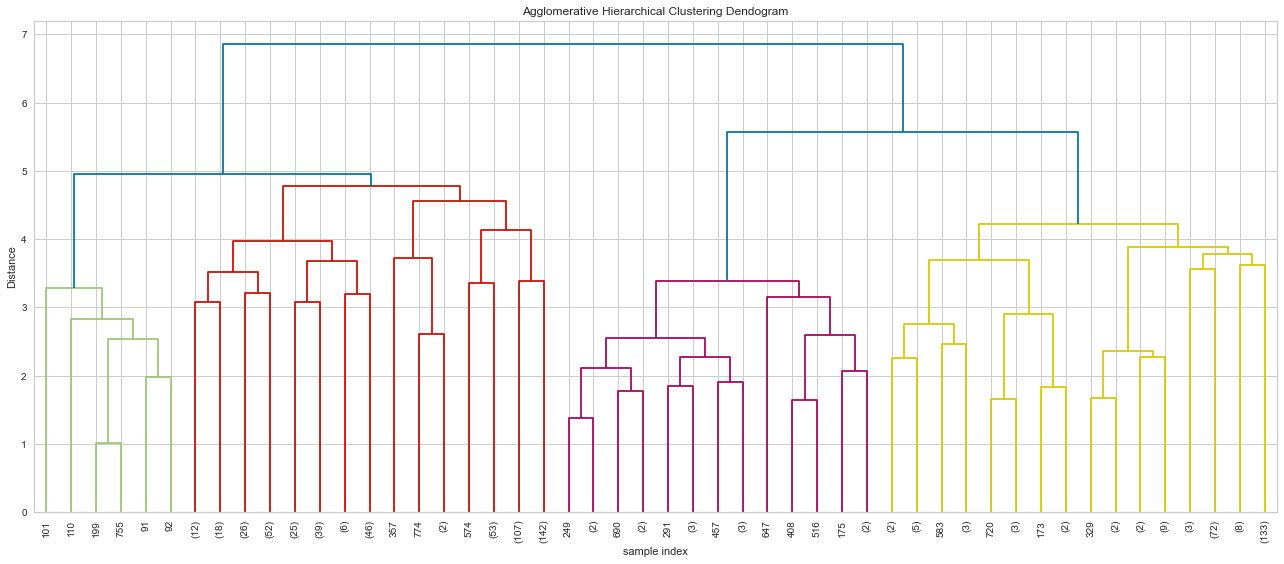

In [41]:
plot_dendogram(data_pca_updated_x, color_threshold = 4.9)

In [42]:
model = AgglomerativeClustering(n_clusters=None , distance_threshold= 4.9
                                  , affinity='euclidean',  linkage='average')
model.fit(data_pca_updated_x);

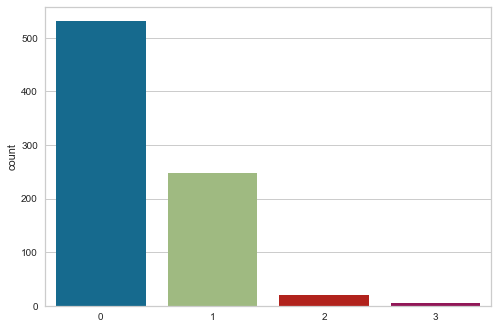

In [43]:
sns.countplot(model.labels_)

In [44]:
data_pca_updated['label_agglo__clus'] = model.labels_
data_pca_updated.groupby('label_agglo__clus')['target'].value_counts(normalize = True)

label_agglo__clus  target
0                  car       0.523622
                   bus       0.238189
                   van       0.238189
1                  car       0.462500
                   bus       0.300000
                   van       0.237500
2                  car       0.500000
                   van       0.277778
                   bus       0.222222
3                  car       0.666667
                   bus       0.333333
Name: target, dtype: float64

* Among cluster 0,1 cars have 50% stake. which proves the model is not perfoming well

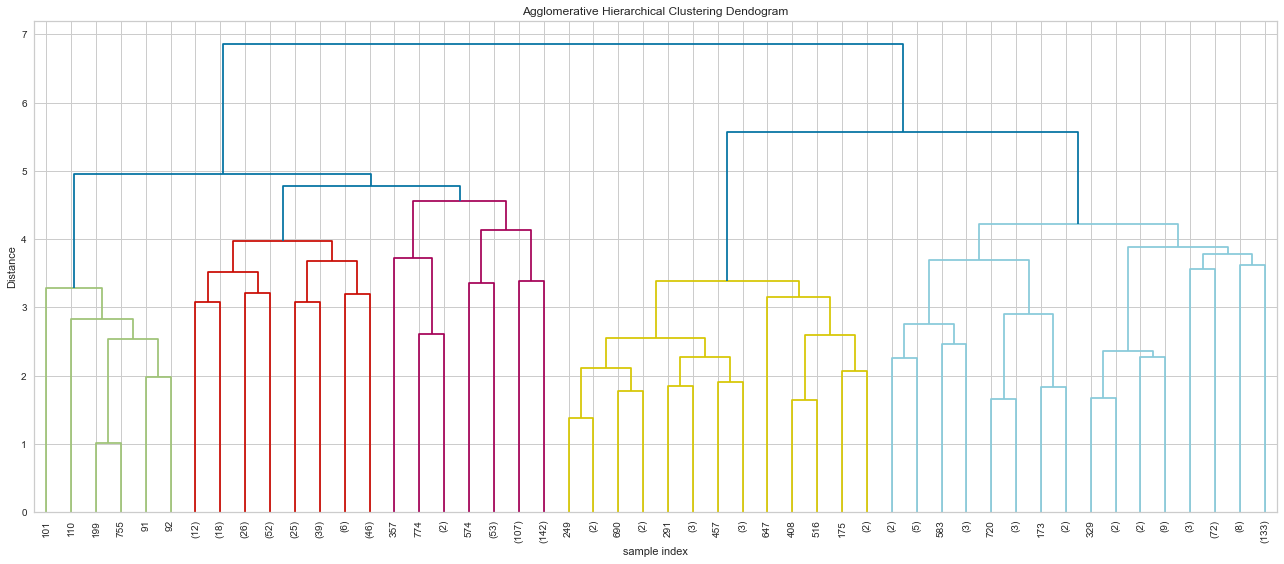

In [45]:
plot_dendogram(data_pca_updated_x, 4.6)

In [46]:
model = AgglomerativeClustering(n_clusters=None , distance_threshold= 4.6
                                  , affinity='euclidean',  linkage='average')
model.fit(data_pca_updated_x);

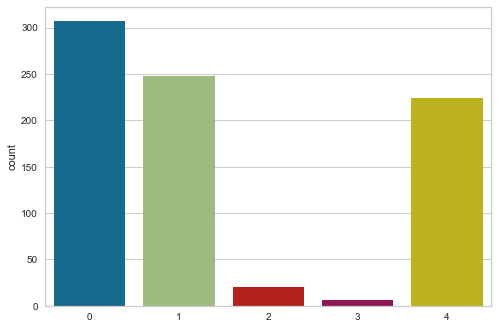

In [47]:
sns.countplot(model.labels_)

In [48]:
data_pca_updated['label_agglo__clus'] = model.labels_
data_pca_updated.groupby('label_agglo__clus')['target'].value_counts(normalize = True)

label_agglo__clus  target
0                  car       0.530405
                   van       0.239865
                   bus       0.229730
1                  car       0.462500
                   bus       0.300000
                   van       0.237500
2                  car       0.500000
                   van       0.277778
                   bus       0.222222
3                  car       0.666667
                   bus       0.333333
4                  car       0.514151
                   bus       0.250000
                   van       0.235849
Name: target, dtype: float64

Among cluster 0,1,4 cars have 50% stake. which proves the model is not perfoming well

### As the data is collected is collected from an image, both(K_means and Aggloramative) algorithms couldn't fit the best model.
#### K_means is performing better than Aggloramative
### KMeans can be used to predict ***cars*** among cars,bus,van